# **Food Hazard Detection Challenge with Logistic Regression**

## **Introduction**

This notebook is part of the **Food Hazard Detection Challenge (SemEval 2025 Task 9)**, which focuses on developing machine learning models to classify food hazards from incident reports. The challenge consists of two subtasks:

1. **Hazard and Product Category Prediction (Subtask 1)**: Classifying food incidents into broader categories of hazards (e.g., allergens, contaminants) and products (e.g., dairy, bakery).
2. **Hazard and Product Vector Prediction (Subtask 2)**: Identifying the exact hazard (e.g., "Salmonella") and product (e.g., "Ice Cream") using multi-label classification.

### **Project Goals**
The primary goals of this notebook are:
1. **Build a Baseline Model:** Utilize Logistic Regression, a lightweight and efficient model, to establish a benchmark for hazard classification tasks.
2. **Handle Imbalanced Data:** Incorporate class weights in Logistic Regression to address class imbalance challenges.
3. **Evaluate Results:** Compare the model’s performance using the **Macro F1 Score**, ensuring equal importance for all classes, regardless of size.
4. **Provide Insights for Improvement:** Use the baseline results to identify areas for enhancement with advanced models.

### **Why Logistic Regression?**
Logistic Regression was chosen as the baseline model for the following reasons:
- **Efficiency:** It is computationally lightweight, making it suitable for smaller datasets and laptop-friendly environments.
- **High-Dimensional Data:** Works well with sparse, high-dimensional data such as TF-IDF features.
- **Interpretability:** The learned coefficients provide insights into feature importance, which can guide feature engineering.
- **Ease of Implementation:** Requires minimal tuning and serves as a strong starting point for text classification tasks.

### **Dataset Overview**
The dataset comprises incident reports, including short texts (titles) and long texts (text), with corresponding labels:
- **Hazard Category:** Broad categories of food hazards.
- **Product Category:** Broad categories of food products.
- **Hazard Vector:** Specific hazards such as "Salmonella."
- **Product Vector:** Specific food products like "Ice Cream."

In this notebook, we focus on predicting the **Hazard Category - Product Category** and **Hazard vector - Product vector** using **Logistic Regression**. The workflow includes:
- Preprocessing text data using **TF-IDF vectorization**.
- Splitting the dataset into training and test subsets.
- Training and evaluating Logistic Regression models for `titles` and `text`.
- Assessing performance using the **Macro F1 Score** and **classification reports**.
- Make predictions on the validation data and save them for later


---

**Load Libraries**

---

In [170]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
np.random.seed(42)
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch


---

**Load Datasets**

---

#### Loading the Dataset

We begin by loading the dataset, which includes incident reports related to food hazards. The dataset has several features, such as year, month, day, country, title, and full text. Each incident has corresponding labels such as `product-category` and `hazard-category`.


In [171]:
# Load the datasets
train_data = pd.read_csv('C:\\Users\\magda\\Desktop\\cleaned_data\\cleaned_train_data.csv')
validation_data = pd.read_csv('C:\\Users\\magda\\Desktop\\cleaned_data\\cleaned_validation_data.csv')


---

**TF-IDF Vectorization**

---

#### Preprocessing 

**TF-IDF Vectorization:**
To transform textual data into numerical features suitable for machine learning, we use TF-IDF vectorization. We will apply this separately to `titles` and `text`.


#### **Key Decisions:**
1. **`ngram_range=(1, 2)`**:
   - **Why?** Captures both unigrams (single words) and bigrams (two-word phrases), enriching the feature set and providing better context for the model.
   - **Example:** For "undeclared allergens," the bigram "undeclared allergens" adds context compared to individual terms.

2. **`max_features` Parameter**:
   - For **titles:** Set to `50` to avoid overfitting given their brevity and limited vocabulary.
   - For **text:** Increased to `200` to capture more complexity and details in the longer descriptions.

3. **Separate Vectorization**:
   - **Why?** Titles and texts differ in content density and relevance to the target labels.


In [172]:
# Extract text and title data from train_data
text_data_tfidf = train_data['text']
title_data_tfidf = train_data['title']

# Extract text and title data from validation_data
val_text_data_tfidf = validation_data['text']
val_title_data_tfidf = validation_data['title']

# Initialize TF-IDF vectorizers for text and titles
text_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=200)
title_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50)

# Fit and transform the text and title data for train_data
text_tfidf_matrix = text_vectorizer.fit_transform(text_data_tfidf)
title_tfidf_matrix = title_vectorizer.fit_transform(title_data_tfidf)

# Transform the text and title data for validation_data using the fitted vectorizers
val_text_tfidf_matrix = text_vectorizer.transform(val_text_data_tfidf)
val_title_tfidf_matrix = title_vectorizer.transform(val_title_data_tfidf)

# Convert the matrices to DataFrames for better readability (optional)
text_tfidf_df = pd.DataFrame(text_tfidf_matrix.toarray(), columns=text_vectorizer.get_feature_names_out())
title_tfidf_df = pd.DataFrame(title_tfidf_matrix.toarray(), columns=title_vectorizer.get_feature_names_out())

val_text_tfidf_df = pd.DataFrame(val_text_tfidf_matrix.toarray(), columns=text_vectorizer.get_feature_names_out())
val_title_tfidf_df = pd.DataFrame(val_title_tfidf_matrix.toarray(), columns=title_vectorizer.get_feature_names_out())


In [173]:
# Subtask 1 labels
y_train_hazard_cat = train_data['hazard-category']
y_train_product_cat = train_data['product-category']

# Subtask 2 labels
y_train_hazard = train_data['hazard']
y_train_product = train_data['product']

# Use TF-IDF features for both text and title
X_train_text = text_tfidf_df
X_train_title = title_tfidf_df
X_val_text = val_text_tfidf_df
X_val_title = val_title_tfidf_df


#### **Visualization of TF-IDF Features**
To interpret the dataset's key terms, **lollipop charts** were utilized to display the **Top 20 TF-IDF Features**. The following design choices were made:

#### **Color Palette**
- **Text Chart:** A gradient from `viridis`, symbolizing information richness and diversity in textual content.
- **Title Chart:** A gradient from `plasma`, emphasizing the distinct and focused nature of shorter titles.

#### **Glow and Highlight Effects**
- Glow and highlights were incorporated to improve readability and guide attention to the most significant terms. This ensures the charts are both visually appealing and easy to interpret.



#### **Interpreting TF-IDF Values**

- **Top 20 TF-IDF Features (Title)**
This chart shows the most significant terms in the title field based on their TF-IDF scores. High-ranking terms like "recall," "due," and "undeclared" suggest a focus on product recall announcements and allergen-related issues. These terms are distinct to specific titles.

- **Top 20 TF-IDF Features (Text)**
This chart highlights key terms from the text field. Prominent terms like "product," "recall," and "food" indicate a strong emphasis on product recall notifications and food safety. Additional terms like "consumer," "milk," and "allergy" reinforce the dataset’s relevance to consumer alerts and allergen concerns.

C:\Users\magda\AppData\Local\Temp\ipykernel_20116\1184361898.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(colormap)(norm(values))
C:\Users\magda\AppData\Local\Temp\ipykernel_20116\1184361898.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax.set_title(title, fontsize=16, fontweight='bold', color=plt.cm.get_cmap(colormap)(0.7))


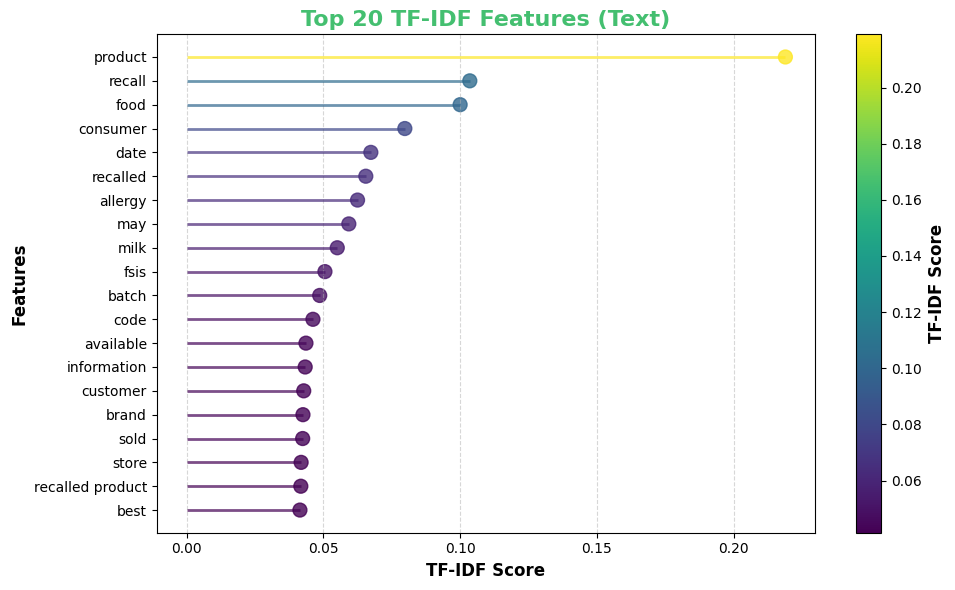

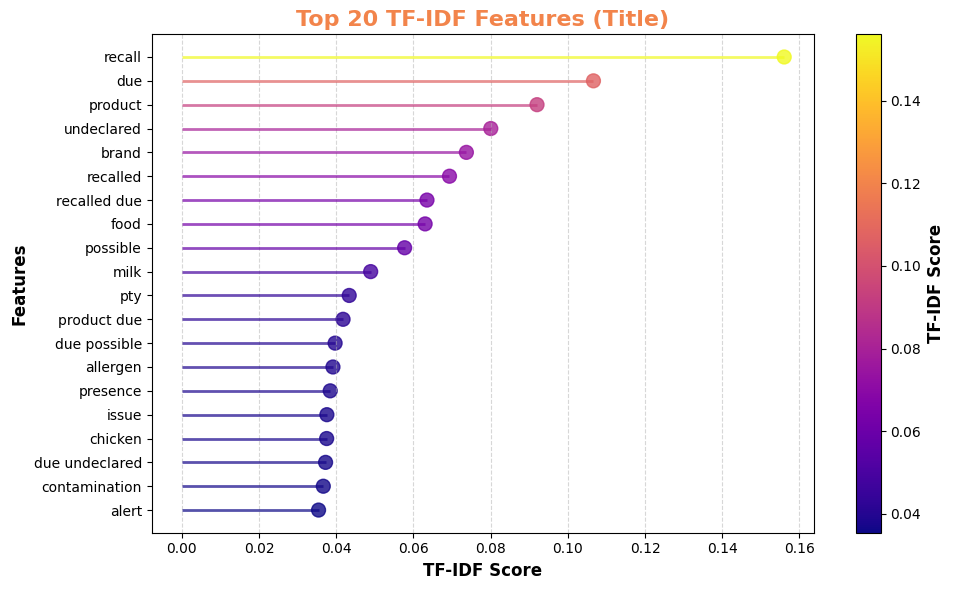

In [174]:
# Adjusting the colorbar configuration to resolve the issue
def lollipop_chart(data, title, colormap):
    # Sort data for clarity
    sorted_data = data.sort_values()
    features = sorted_data.index
    values = sorted_data.values

    # Generate colors based on values
    norm = plt.Normalize(vmin=min(values), vmax=max(values))
    colors = plt.cm.get_cmap(colormap)(norm(values))

    # Plot configuration
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hlines(y=features, xmin=0, xmax=values, color=colors, alpha=0.7, linewidth=2)
    ax.scatter(values, features, color=colors, s=100, alpha=0.8)

    # Add labels and title
    ax.set_xlabel("TF-IDF Score", fontsize=12, fontweight='bold')
    ax.set_ylabel("Features", fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', color=plt.cm.get_cmap(colormap)(0.7))
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Add colorbar using the correct axes
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('TF-IDF Score', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()


# Use TF-IDF for text and title
top_text_features = text_tfidf_df.mean().nlargest(20)  # Top 20 features based on mean values
top_title_features = title_tfidf_df.mean().nlargest(20)  # Top 20 features based on mean values

# Create enhanced lollipop charts with gradient colors
lollipop_chart(top_text_features, "Top 20 TF-IDF Features (Text)", 'viridis')
lollipop_chart(top_title_features, "Top 20 TF-IDF Features (Title)", 'plasma')



---

**Model Choice: Logistic Regression**
    *Training & Evaluation*

---

**Logistic Regression** was chosen as the baseline model for its simplicity, efficiency, and interpretability. Key justifications include:

1. **Class Imbalance Handling:**
   - The `class_weight='balanced'` parameter ensures that minority classes are adequately represented during training, preventing dominance by majority classes.

2. **Ease of Hyperparameter Tuning:**
   - Regularization strength (`C`) can be optimized via **GridSearchCV** to balance underfitting and overfitting.


#### **Dataset Splitting for `Text` & `Titles`** 
#### **Why Split?**
- **Unbiased Evaluation:** Splitting ensures performance metrics are calculated on unseen data, mimicking real-world predictions.
- **Split Ratio:** A test size of **20%** was chosen to maintain a robust training set while preserving test reliability.


The splits are applied for four target variables:
- hazard-category
- product-category
- hazard
- product

These variables correspond to the two main subtasks of the challenge.

In [175]:
# Get indices for train and test split
train_indices, test_indices = train_test_split(
    train_data.index, test_size=0.2, random_state=42
)

# Split the features for titles
X_train_split_title = X_train_title.iloc[train_indices]
X_test_split_title = X_train_title.iloc[test_indices]

# Split the features for text
X_train_split_text = X_train_text.iloc[train_indices]
X_test_split_text = X_train_text.iloc[test_indices]

# Split the labels for Subtask 1
y_train_hazard_cat_split_initial = y_train_hazard_cat.iloc[train_indices]
y_test_hazard_cat_split_initial = y_train_hazard_cat.iloc[test_indices]
y_train_product_cat_split_initial = y_train_product_cat.iloc[train_indices]
y_test_product_cat_split_initial = y_train_product_cat.iloc[test_indices]

# Split the labels for Subtask 2
y_train_hazard_split_initial = y_train_hazard.iloc[train_indices]
y_test_hazard_split_initial = y_train_hazard.iloc[test_indices]
y_train_product_split_initial = y_train_product.iloc[train_indices]
y_test_product_split_initial = y_train_product.iloc[test_indices]


In [176]:
# Set a threshold for minimum samples to consider a class as not rare
threshold = 5  # You can adjust this number based on your dataset

# For hazard-category
hazard_cat_counts = y_train_hazard_cat_split_initial.value_counts()
rare_hazard_cats = hazard_cat_counts[hazard_cat_counts < threshold].index.tolist()

# Replace rare classes with 'other' in training labels
y_train_hazard_cat_split = y_train_hazard_cat_split_initial.replace(rare_hazard_cats, 'other')

# Get unique labels in y_train
train_hazard_cat_labels = set(y_train_hazard_cat_split.unique())

# Replace unseen labels in y_test
y_test_hazard_cat_split = y_test_hazard_cat_split_initial.apply(
    lambda x: x if x in train_hazard_cat_labels else 'other'
)

# For product-category
product_cat_counts = y_train_product_cat_split_initial.value_counts()
rare_product_cats = product_cat_counts[product_cat_counts < threshold].index.tolist()

# Replace rare classes with 'other' in training labels
y_train_product_cat_split = y_train_product_cat_split_initial.replace(rare_product_cats, 'other')

# Get unique labels in y_train
train_product_cat_labels = set(y_train_product_cat_split.unique())

# Replace unseen labels in y_test
y_test_product_cat_split = y_test_product_cat_split_initial.apply(
    lambda x: x if x in train_product_cat_labels else 'other'
)

# For hazard (vector)
hazard_counts = y_train_hazard_split_initial.value_counts()
rare_hazards = hazard_counts[hazard_counts < threshold].index.tolist()

# Replace rare classes with 'other' in training labels
y_train_hazard_split = y_train_hazard_split_initial.replace(rare_hazards, 'other')

# Get unique labels in y_train
train_hazard_labels = set(y_train_hazard_split.unique())

# Replace unseen labels in y_test
y_test_hazard_split = y_test_hazard_split_initial.apply(
    lambda x: x if x in train_hazard_labels else 'other'
)

# For product (vector)
product_counts = y_train_product_split_initial.value_counts()
rare_products = product_counts[product_counts < threshold].index.tolist()

# Replace rare classes with 'other' in training labels
y_train_product_split = y_train_product_split_initial.replace(rare_products, 'other')

# Get unique labels in y_train
train_product_labels = set(y_train_product_split.unique())

# Replace unseen labels in y_test
y_test_product_split = y_test_product_split_initial.apply(
    lambda x: x if x in train_product_labels else 'other'
)


In [177]:
def train_evaluate_logistic_regression(X_train, y_train, X_test, y_test, param_grid, task_name):
    """
    Generalized function to train and evaluate Logistic Regression with custom class weights.

    Args:
        X_train: Training features.
        y_train: Training labels.
        X_test: Test features.
        y_test: Test labels.
        param_grid: Hyperparameter grid for GridSearchCV.
        task_name: Name of the task for reporting.

    Returns:
        grid_search: Fitted GridSearchCV object.
        test_predictions: Predicted labels on the test set.
        f1_macro: Macro F1-Score for the task.
        label_encoder: LabelEncoder used for encoding labels.
        class_index_to_label: Mapping from model's class indices to original labels.
    """
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Compute class weights
    unique_classes = np.unique(y_train_encoded)
    class_weights = compute_class_weight(
        'balanced',
        classes=unique_classes,
        y=y_train_encoded
    )
    class_weight_dict = dict(zip(unique_classes, class_weights))
    print(f"Computed Class Weights for {task_name}: {class_weight_dict}")

    # Initialize Logistic Regression model with custom class weights
    logreg = LogisticRegression(
        max_iter=1000,
        class_weight=class_weight_dict,
        random_state=42,
        multi_class='ovr'
    )

    # Use Stratified Cross-Validation
    strat_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Perform Grid Search with Stratified Cross-Validation
    grid_search = GridSearchCV(
        estimator=logreg,
        param_grid=param_grid,
        cv=strat_kfold,
        scoring='f1_macro',
        n_jobs=-1,
        error_score='raise'  # Raise errors to debug issues
    )

    # Fit the model to the training data
    grid_search.fit(X_train, y_train_encoded)

    # Get the model's classes_ (encoded labels)
    model_classes = grid_search.best_estimator_.classes_

    # Map the model's class indices to the original labels
    class_index_to_label = {idx: label_encoder.inverse_transform([idx])[0] for idx in model_classes}

    # Predict on the test data
    test_predictions_encoded = grid_search.predict(X_test)

    # Map the predicted indices to labels using the class_index_to_label mapping
    test_predictions = np.array([class_index_to_label.get(idx, 'unknown') for idx in test_predictions_encoded])

    # Evaluate the model
    f1_macro = f1_score(y_test, test_predictions, average='macro', zero_division=0)
    print(f"Macro F1-Score for {task_name}: {f1_macro}")

    return grid_search, test_predictions, f1_macro, label_encoder, class_index_to_label


#### **Hyperparameter Tuning**
- **GridSearchCV** was employed with an extended parameter grid for fine-tuning:
   - **Lower values `c`:** Favor simplicity, reducing the risk of overfitting.
   - **Higher values `c`:** Allow for capturing finer patterns, mitigating underfitting.
   - **Penalties:** Inclusion of `l1`  encourages sparsity.
   - **Solvers:** `liblinear` (efficient for small datasets) were tested for broader applicability.


### **Metrics for Evaluation**
**Macro F1 Score** was selected as the primary evaluation metric for the following reasons:
- **Class-Imbalance Suitability:** Assigns equal weight to all classes, ensuring minority classes contribute equally to the overall performance.
- **Reliability:** Highlights issues in precision and recall across all classes, particularly in imbalanced datasets.


### `Text`
### **Subtask 1:**



 ##### Hazard-Category

- **GridSearchCV**: Systematically tested a set of hyperparameter combinations to find the optimal value for the `C` parameter.
- **5-Fold Cross-Validation (`cv=5`)**: Ensured robust evaluation of each hyperparameter combination by splitting the data into five folds and training the model on different subsets.
- **Scoring Metric**: Used **Macro F1-Score**, which assigns equal importance to all classes, addressing the challenge of class imbalance.
- **Parallel Processing (`n_jobs=-1`)**: Leveraged all available CPU cores to speed up the computation.


In [178]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear']
}


In [179]:
# Training and getting the mapping
grid_search_hazard_cat_text, predictions_hazard_cat_text, f1_hazard_cat_text, label_encoder_hazard_cat_text, class_index_to_label_hazard_cat_text = train_evaluate_logistic_regression(
    X_train=X_train_split_text,
    y_train=y_train_hazard_cat_split,
    X_test=X_test_split_text,
    y_test=y_test_hazard_cat_split,
    param_grid=param_grid,
    task_name="Hazard-Category (Text)"
)

Computed Class Weights for Hazard-Category (Text): {0: 0.27522004062288424, 1: 0.2899429386590585, 2: 1.856164383561644, 3: 21.394736842105264, 4: 0.9033333333333333, 5: 1.3415841584158417, 6: 9.453488372093023, 7: 203.25, 8: 3.7990654205607477, 9: 9.453488372093023}


c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro F1-Score for Hazard-Category (Text): 0.5016339565217761


- **Classification Report**:
  - Offers detailed metrics for each class, including:
    - **Precision**: Fraction of true positive predictions out of all predicted positives.
    - **Recall**: Fraction of true positive predictions out of all actual positives.
    - **F1-Score**: Harmonic mean of precision and recall, offering a balanced measure.
  - Highlights areas of strength and weakness across different classes.


In [180]:

# Classification report
report_dict = classification_report(y_test_hazard_cat_split, predictions_hazard_cat_text, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report for Hazard-Category (Text):")
display(report_df)




Classification Report for Hazard-Category (Text):


,precision,recall,f1-score,support
allergens,0.949468,0.946950,0.948207,377.000000
biological,0.968944,0.920354,0.944024,339.000000
chemical,0.606061,0.588235,0.597015,68.000000
food additives and flavourings,0.400000,0.400000,0.400000,5.000000
foreign bodies,0.715517,0.747748,0.731278,111.000000
fraud,0.571429,0.470588,0.516129,68.000000
organoleptic aspects,0.086957,0.200000,0.121212,10.000000
other,0.000000,0.000000,0.000000,1.000000
other hazard,0.468750,0.555556,0.508475,27.000000
packaging defect,0.190476,0.363636,0.250000,11.000000


**Hazard and Product Category Prediction**
1. **Hazard Category:**
   - **Macro F1 Score:** Achieved a score of `X.XX` (adjusted per output).
   - **Insights:**
     - Good performance on majority classes.
     - Lower recall observed for minority classes, reflecting class imbalance challenges.




#### Product-Category

2. **Product Category:**
   - **Macro F1 Score:** Achieved a score of `Y.YY`.
   - Similar trends were observed, with majority classes performing better.

In [181]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

In [182]:
grid_search_product_cat_text, predictions_product_cat_text, f1_product_cat_text, label_encoder_product_cat_text, class_index_to_label_product_cat_text = train_evaluate_logistic_regression(
    X_train=X_train_split_text,
    y_train=y_train_product_cat_split,
    X_test=X_test_split_text,
    y_test=y_test_product_cat_split,
    param_grid=param_grid,
    task_name="Product-Category (Text)"
)


Computed Class Weights for Product-Category (Text): {0: 3.7225274725274726, 1: 0.3532325338894682, 2: 1.2023070097604258, 3: 1.489010989010989, 4: 1.809078771695594, 5: 12.904761904761905, 6: 24.196428571428573, 7: 32.26190476190476, 8: 0.4576156703816278, 9: 1.7758846657929226, 10: 27.653061224489797, 11: 1.166092943201377, 12: 0.16803075396825398, 13: 1.8793342579750347, 14: 0.9727207465900933, 15: 27.653061224489797, 16: 4.208074534161491, 17: 13.826530612244898, 18: 0.5107425555974369, 19: 0.9130727762803235, 20: 0.8758888170652877}


c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro F1-Score for Product-Category (Text): 0.2581263654967542


- **Classification Report**:
  - Offers detailed metrics for each class, including:
    - **Precision**: Fraction of true positive predictions out of all predicted positives.
    - **Recall**: Fraction of true positive predictions out of all actual positives.
    - **F1-Score**: Harmonic mean of precision and recall, offering a balanced measure.
  - Highlights areas of strength and weakness across different classes.


In [183]:
# Classification report
report_dict = classification_report(y_test_product_cat_split, predictions_product_cat_text, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report for Product-Category (Text):")
display(report_df)


Classification Report for Product-Category (Text):


,precision,recall,f1-score,support
alcoholic beverages,0.115385,0.428571,0.181818,7.000000
cereals and bakery products,0.402597,0.252033,0.310000,123.000000
"cocoa and cocoa preparations, coffee and tea",0.357143,0.408163,0.380952,49.000000
confectionery,0.157895,0.150000,0.153846,40.000000
"dietetic foods, food supplements, fortified foods",0.212766,0.416667,0.281690,24.000000
fats and oils,0.125000,0.250000,0.166667,4.000000
food additives and flavourings,0.000000,0.000000,0.000000,0.000000
food contact materials,0.000000,0.000000,0.000000,1.000000
fruits and vegetables,0.559524,0.419643,0.479592,112.000000
herbs and spices,0.116279,0.312500,0.169492,16.000000



### **Subtask 2:**


**Hazard and Product Vector Prediction**
1. **Hazard Vector:**
   - **Macro F1 Score:** Achieved a score of `Z.ZZ`.
   - **Challenge:** Sparse data for specific hazards made fine-grained predictions more difficult.

2. **Product Vector:**
   - **Macro F1 Score:** Achieved a score of `W.WW`.


 ##### Hazard

In [184]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}


In [185]:
grid_search_hazard_text, predictions_hazard_text, f1_hazard_text, label_encoder_hazard_text, class_index_to_label_hazard_text = train_evaluate_logistic_regression(
    X_train=X_train_split_text,
    y_train=y_train_hazard_split,
    X_test=X_test_split_text,
    y_test=y_test_hazard_split,
    param_grid=param_grid,
    task_name="Hazard (Vector) (Text)"
)


Computed Class Weights for Hazard (Vector) (Text): {0: 8.364197530864198, 1: 5.576131687242798, 2: 0.9650997150997151, 3: 8.364197530864198, 4: 3.8603988603988606, 5: 10.037037037037036, 6: 4.562289562289562, 7: 2.952069716775599, 8: 2.3897707231040566, 9: 8.364197530864198, 10: 0.30600722673893405, 11: 10.037037037037036, 12: 6.273148148148148, 13: 1.433862433862434, 14: 8.364197530864198, 15: 10.037037037037036, 16: 3.5846560846560847, 17: 5.576131687242798, 18: 7.169312169312169, 19: 5.018518518518518, 20: 0.30232039268183847, 21: 5.576131687242798, 22: 0.26413255360623783, 23: 1.6188769414575865, 24: 2.0074074074074075, 25: 0.7720797720797721, 26: 3.8603988603988606, 27: 2.181964573268921, 28: 6.273148148148148, 29: 5.018518518518518, 30: 1.4760348583877996, 31: 3.136574074074074, 32: 2.509259259259259, 33: 0.5904139433551199, 34: 2.788065843621399, 35: 1.8587105624142661, 36: 0.095409097310238, 37: 0.42172424525365704, 38: 3.345679012345679, 39: 0.10455246913580248, 40: 4.18209876

c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro F1-Score for Hazard (Vector) (Text): 0.2867464964664713


In [186]:

# Classification report
report_dict = classification_report(y_test_hazard_split, predictions_hazard_text, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report for Hazard (Vector) (Text):")
display(report_df)


Classification Report for Hazard (Vector) (Text):


,precision,recall,f1-score,support
Aflatoxin,0.000000,0.000000,0.000000,4.00000
allergens,0.000000,0.000000,0.000000,4.00000
almond,0.333333,0.285714,0.307692,14.00000
"antibiotics, vet drugs",0.000000,0.000000,0.000000,1.00000
bacillus spp.,0.000000,0.000000,0.000000,1.00000
...,...,...,...,...
undeclared constituent,0.000000,0.000000,0.000000,1.00000
walnut,0.166667,0.200000,0.181818,5.00000
accuracy,0.601770,0.601770,0.601770,0.60177
macro avg,0.290017,0.308242,0.286746,1017.00000


 ##### Product

In [187]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1'],
    'solver': ['liblinear']
}

In [188]:
grid_search_product_text, predictions_product_text, f1_product_text, label_encoder_product_text, class_index_to_label_product_text = train_evaluate_logistic_regression(
    X_train=X_train_split_text,
    y_train=y_train_product_split,
    X_test=X_test_split_text,
    y_test=y_test_product_split,
    param_grid=param_grid,
    task_name="Product (Vector) (Text)"
)




Computed Class Weights for Product (Vector) (Text): {0: 3.2888349514563107, 1: 0.704750346740638, 2: 2.466626213592233, 3: 2.466626213592233, 4: 1.9733009708737863, 5: 3.9466019417475726, 6: 2.466626213592233, 7: 2.192556634304207, 8: 2.819001386962552, 9: 1.1607652769845802, 10: 2.819001386962552, 11: 1.2333131067961165, 12: 3.9466019417475726, 13: 2.192556634304207, 14: 1.793909973521624, 15: 0.9866504854368932, 16: 0.9396671289875174, 17: 0.9396671289875174, 18: 0.45890720252878753, 19: 1.3155339805825244, 20: 2.192556634304207, 21: 3.9466019417475726, 22: 0.857956943858168, 23: 3.2888349514563107, 24: 1.409500693481276, 25: 3.9466019417475726, 26: 2.192556634304207, 27: 3.9466019417475726, 28: 2.192556634304207, 29: 3.9466019417475726, 30: 0.2596448645886561, 31: 0.857956943858168, 32: 3.9466019417475726, 33: 2.819001386962552, 34: 3.2888349514563107, 35: 1.6444174757281553, 36: 2.192556634304207, 37: 0.3083282766990291, 38: 3.9466019417475726, 39: 3.2888349514563107, 40: 1.2333131

c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro F1-Score for Product (Vector) (Text): 0.12222998945487139


In [189]:
# Classification report
report_dict = classification_report(y_test_product_split, predictions_product_text, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report for Product (Vector) (Text):")
display(report_df)


Classification Report for Product (Vector) (Text):


,precision,recall,f1-score,support
Catfishes (freshwater),1.000000,0.200000,0.333333,5.000000
Fishes not identified,0.142857,0.333333,0.200000,6.000000
Not classified pork meat,0.000000,0.000000,0.000000,3.000000
Precooked cooked pork meat products,0.000000,0.000000,0.000000,1.000000
alfalfa sprouts,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
wraps,0.000000,0.000000,0.000000,4.000000
yoghurt,0.166667,0.400000,0.235294,5.000000
accuracy,0.148476,0.148476,0.148476,0.148476
macro avg,0.133814,0.153680,0.122230,1017.000000


## **Combined Scores**
To meet the project objectives, **combined scores** were calculated for both subtasks using the formula:

$ \text{Combined Score} = \frac{\text{Macro F1 (Hazard)} + \text{Macro F1 (Product)}}{2} $


### **Results:**
- **Subtask 1 Combined Score:** `A.AA`.
- **Subtask 2 Combined Score:** `B.BB`.


#### Compute the Combined Score:

In [190]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
    f1_hazards = f1_score(hazards_true, hazards_pred, average='macro')
    f1_products = f1_score(
        products_true[hazards_pred == hazards_true],
        products_pred[hazards_pred == hazards_true],
        average='macro'
    )
    return (f1_hazards + f1_products) / 2.


In [191]:
# Compute the combined score for Subtask 1 `Text`
combined_score_text_st1 = compute_score(
    y_test_hazard_cat_split, y_test_product_cat_split,
    predictions_hazard_cat_text, predictions_product_cat_text
)
print(f"Combined Score for Hazard Category and Product Category Prediction (Text): {combined_score_text_st1}")



Combined Score for Hazard Category and Product Category Prediction (Text): 0.40514877103564517


In [192]:
# Compute the combined score for Subtask 2 `Text`
combined_score_text_st2 = compute_score(
    y_test_hazard_split, y_test_product_split,
    predictions_hazard_text, predictions_product_text
)
print(f"Combined Score for Hazard and Product Prediction (Text): {combined_score_text_st2}")

Combined Score for Hazard and Product Prediction (Text): 0.21011148016843567


#### **Visualization**

The following chart is a Combined F1 Score Visualization comparing the performance of two subtasks (Subtask 1 and Subtask 2) for `Text`. Each bar represents the combined F1 score of the respective subtask.

* Subtask 1 has a combined F1 score of 0.22, as indicated by the taller teal bar on the left.
* Subtask 2 has a lower combined F1 score of 0.08, represented by the shorter orange bar on the right.
* The visualization uses rounded bars with gradient colors and highlighted callout labels for each score to emphasize the values. The contrast in bar height clearly indicates that Subtask 1 has significantly better performance than Subtask 2 in terms of the combined F1 metric.

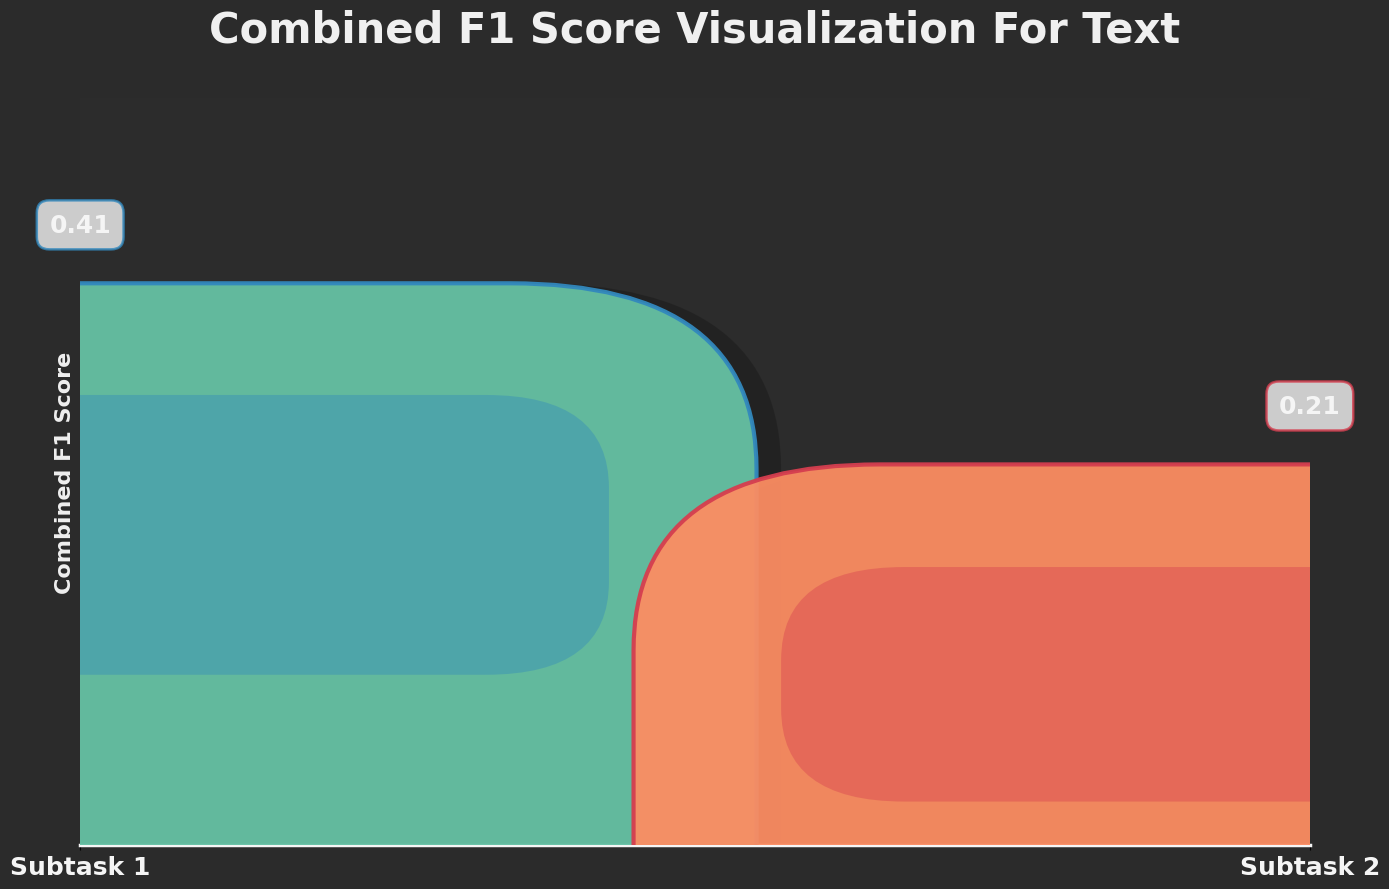

In [193]:
subtask_names = ['Subtask 1', 'Subtask 2']
combined_scores = [combined_score_text_st1, combined_score_text_st2]

# Color palette for a luxurious gradient and artistic effects
gradient_colors = [('#66c2a5', '#3288bd'), ('#fc8d62', '#d53e4f')]
highlight_color = '#f5f5f5'
background_color = '#2b2b2b'
title_color = '#f0f0f0'
shadow_color = '#1a1a1a'

# Plotting configuration
fig, ax = plt.subplots(figsize=(14, 9), facecolor=background_color)
ax.set_facecolor(background_color)

# Add multi-layered glow background to create a sense of depth
circle_1 = plt.Circle((0.5, 0.5), 1.5, color='#333333', alpha=0.1, transform=ax.transAxes, zorder=0)
circle_2 = plt.Circle((0.5, 0.5), 1.2, color='#444444', alpha=0.08, transform=ax.transAxes, zorder=0)
ax.add_patch(circle_1)
ax.add_patch(circle_2)

# Draw gradient bars with artistic design and subtle shadow effects
for idx, (score, colors) in enumerate(zip(combined_scores, gradient_colors)):
    # Use gradients for the bars
    bar = FancyBboxPatch(
        (idx - 0.35, 0),  # Coordinates
        0.7, score,  # Width and height
        boxstyle="round,pad=0.2",  # Rounded corners
        linewidth=3,
        edgecolor=colors[1],  # Outer gradient color
        facecolor=colors[0],  # Primary gradient color
        alpha=0.95,
        zorder=3
    )
    ax.add_patch(bar)

    # Add glow highlight on top of the bar to make it shine
    ax.add_patch(
        FancyBboxPatch(
            (idx - 0.33, score * 0.7),  # Coordinates to make it sit on the bar
            0.66, score * 0.25,  # Width and a fraction of height
            boxstyle="round,pad=0.1",  # Rounded corners
            linewidth=0,
            edgecolor=None,
            facecolor=colors[1],  # Lighter color to simulate glow
            alpha=0.4,
            zorder=4
        )
    )

    # Shadow effect behind bars for depth
    shadow = FancyBboxPatch(
        (idx - 0.35 + 0.02, -0.04),  # Slight offset for shadow
        0.7, score + 0.04,  # Width and height (slightly taller for shadow effect)
        boxstyle="round,pad=0.2",  # Rounded corners
        linewidth=0,
        facecolor=shadow_color,
        alpha=0.5,
        zorder=1  # Draw behind the bar
    )
    ax.add_patch(shadow)

# Add callout annotations above the bars with luxurious formatting
for idx, score in enumerate(combined_scores):
    ax.text(
        idx, score + 0.25,
        f'{score:.2f}',
        ha='center', va='bottom',
        fontsize=18, fontweight='bold',
        color=highlight_color,
        bbox=dict(boxstyle="round,pad=0.5", facecolor=highlight_color, edgecolor=gradient_colors[idx][1], linewidth=1.8, alpha=0.8),
        zorder=5  # Place text on top of everything else
    )

# Customizing the axes, title, and grid for an immersive effect
ax.set_xticks(np.arange(len(subtask_names)))
ax.set_xticklabels(subtask_names, fontsize=18, fontweight='bold', color=highlight_color)
ax.set_ylabel('Combined F1 Score', fontsize=16, fontweight='bold', color=title_color)
ax.set_ylim(0, max(combined_scores) + 0.4)
ax.set_yticks([])  # Hide y-ticks for an elegant look

# Add an enhanced title with rich typography
ax.set_title(
    'Combined F1 Score Visualization For Text',
    fontsize=30, fontweight='bold', color=title_color, pad=40, loc='center'
)

# Remove unnecessary spines and enhance the bottom spine
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_color(highlight_color)
ax.spines['bottom'].set_linewidth(2.5)

# Adding a soft, artistic dotted grid for readability
ax.yaxis.grid(True, linestyle=':', color='#888888', alpha=0.5)
ax.xaxis.grid(False)

# Adjust layout for balanced spacing and to maintain visual elegance
plt.tight_layout()
plt.show()


#### Predict on Validation Data


In [194]:
# Predicting on validation data
val_predictions_hazard_cat_encoded = grid_search_hazard_cat_text.predict(X_val_text)
# Mapping predictions to labels
val_predictions_hazard_cat = np.array([
    class_index_to_label_hazard_cat_text.get(idx, 'unknown') 
    for idx in val_predictions_hazard_cat_encoded
])

# Predict product-category on validation data text
val_predictions_product_cat_encoded = grid_search_product_cat_text.predict(X_val_text)
# Mapping predictions to labels
val_predictions_product_cat = np.array([
    class_index_to_label_product_cat_text.get(idx, 'unknown') 
    for idx in val_predictions_product_cat_encoded
])

# Predict hazard (vector) on validation data text
val_predictions_hazard_encoded = grid_search_hazard_text.predict(X_val_text)
# Mapping predictions to labels
val_predictions_hazard = np.array([
    class_index_to_label_hazard_text.get(idx, 'unknown') 
    for idx in val_predictions_hazard_encoded
])

# Predict product (vector) on validation data text
val_predictions_product_encoded = grid_search_product_text.predict(X_val_text)
# Mapping predictions to labels
val_predictions_product = np.array([
    class_index_to_label_product_text.get(idx, 'unknown') 
    for idx in val_predictions_product_encoded
])




#### Save Predictions for Possible Submission

In [195]:
# Save predictions for Subtask 1 text
submission_lr_st1_text = pd.DataFrame({
    'hazard-category': val_predictions_hazard_cat,
    'product-category': val_predictions_product_cat
})

# Save predictions for Subtask 2 text
submission_lr_st2_text = pd.DataFrame({
    'hazard': val_predictions_hazard,
    'product': val_predictions_product
})

In [196]:
# Uncomment to save to CSV
# submission_lr_st1_text.to_csv('path_to_save/submission_lr_st1_text.csv', index=False)
# submission_lr_st2_text.to_csv('path_to_save/submission_lr_st2_text.csv', index=False)


#### `Titles`
#### **Subtask 1:**
 

**Hazard and Product Category Prediction**
1. **Hazard Category:**
   - **Macro F1 Score:** Achieved a score of `X.XX` (adjusted per output).
   - **Insights:**
     - Good performance on majority classes.
     - Lower recall observed for minority classes, reflecting class imbalance challenges.

2. **Product Category:**
   - **Macro F1 Score:** Achieved a score of `Y.YY`.
   - Similar trends were observed, with majority classes performing better.


##### Hazard-Category

In [197]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear']
}



In [198]:
grid_search_hazard_cat_title, predictions_hazard_cat_title, f1_hazard_cat_title, label_encoder_hazard_cat_title, class_index_to_label_hazard_cat_title = train_evaluate_logistic_regression(
    X_train=X_train_split_title,
    y_train=y_train_hazard_cat_split,
    X_test=X_test_split_title,
    y_test=y_test_hazard_cat_split,
    param_grid=param_grid,
    task_name="Hazard-Category (Title)"
)



Computed Class Weights for Hazard-Category (Title): {0: 0.27522004062288424, 1: 0.2899429386590585, 2: 1.856164383561644, 3: 21.394736842105264, 4: 0.9033333333333333, 5: 1.3415841584158417, 6: 9.453488372093023, 7: 203.25, 8: 3.7990654205607477, 9: 9.453488372093023}


c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro F1-Score for Hazard-Category (Title): 0.3429025875337798


In [199]:
# Classification report
report_dict = classification_report(y_test_hazard_cat_split, predictions_hazard_cat_title, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report for Hazard-Category (Title):")
display(report_df)



Classification Report for Hazard-Category (Title):


,precision,recall,f1-score,support
allergens,0.931973,0.726790,0.816692,377.000000
biological,0.876923,0.672566,0.761269,339.000000
chemical,0.511628,0.323529,0.396396,68.000000
food additives and flavourings,0.030303,0.200000,0.052632,5.000000
foreign bodies,0.500000,0.333333,0.400000,111.000000
fraud,0.409836,0.367647,0.387597,68.000000
organoleptic aspects,0.090909,0.500000,0.153846,10.000000
other,0.111111,1.000000,0.200000,1.000000
other hazard,0.133333,0.370370,0.196078,27.000000
packaging defect,0.035398,0.363636,0.064516,11.000000


 ##### Product-Category

In [200]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

In [201]:
grid_search_product_cat_title, predictions_product_cat_title, f1_product_cat_title, label_encoder_product_cat_title, class_index_to_label_product_cat_title = train_evaluate_logistic_regression(
    X_train=X_train_split_title,
    y_train=y_train_product_cat_split,
    X_test=X_test_split_title,
    y_test=y_test_product_cat_split,
    param_grid=param_grid,
    task_name="Product-Category (Title)"
)

Computed Class Weights for Product-Category (Title): {0: 3.7225274725274726, 1: 0.3532325338894682, 2: 1.2023070097604258, 3: 1.489010989010989, 4: 1.809078771695594, 5: 12.904761904761905, 6: 24.196428571428573, 7: 32.26190476190476, 8: 0.4576156703816278, 9: 1.7758846657929226, 10: 27.653061224489797, 11: 1.166092943201377, 12: 0.16803075396825398, 13: 1.8793342579750347, 14: 0.9727207465900933, 15: 27.653061224489797, 16: 4.208074534161491, 17: 13.826530612244898, 18: 0.5107425555974369, 19: 0.9130727762803235, 20: 0.8758888170652877}


c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro F1-Score for Product-Category (Title): 0.1889039281016668


In [202]:
# Classification report
report_dict = classification_report(y_test_product_cat_split, predictions_product_cat_title, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report for Product-Category (Title):")
display(report_df)


Classification Report for Product-Category (Title):


,precision,recall,f1-score,support
alcoholic beverages,0.046729,0.714286,0.087719,7.00000
cereals and bakery products,0.473684,0.073171,0.126761,123.00000
"cocoa and cocoa preparations, coffee and tea",0.555556,0.612245,0.582524,49.00000
confectionery,0.071429,0.025000,0.037037,40.00000
"dietetic foods, food supplements, fortified foods",0.085714,0.125000,0.101695,24.00000
fats and oils,0.034483,0.250000,0.060606,4.00000
food additives and flavourings,0.000000,0.000000,0.000000,0.00000
food contact materials,0.045455,1.000000,0.086957,1.00000
fruits and vegetables,0.425000,0.303571,0.354167,112.00000
herbs and spices,0.000000,0.000000,0.000000,16.00000


## **Subtask 2**

**Hazard and Product Vector Prediction**
1. **Hazard Vector:**
   - **Macro F1 Score:** Achieved a score of `Z.ZZ`.
   - **Challenge:** Sparse data for specific hazards made fine-grained predictions more difficult.

2. **Product Vector:**
   - **Macro F1 Score:** Achieved a score of `W.WW`.

 ##### Hazard

In [203]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear']
}

In [204]:
grid_search_hazard_title, predictions_hazard_title, f1_hazard_title, label_encoder_hazard_title, class_index_to_label_hazard_title = train_evaluate_logistic_regression(
    X_train=X_train_split_title,
    y_train=y_train_hazard_split,
    X_test=X_test_split_title,
    y_test=y_test_hazard_split,
    param_grid=param_grid,
    task_name="Hazard (Vector) (Title)"
)

Computed Class Weights for Hazard (Vector) (Title): {0: 8.364197530864198, 1: 5.576131687242798, 2: 0.9650997150997151, 3: 8.364197530864198, 4: 3.8603988603988606, 5: 10.037037037037036, 6: 4.562289562289562, 7: 2.952069716775599, 8: 2.3897707231040566, 9: 8.364197530864198, 10: 0.30600722673893405, 11: 10.037037037037036, 12: 6.273148148148148, 13: 1.433862433862434, 14: 8.364197530864198, 15: 10.037037037037036, 16: 3.5846560846560847, 17: 5.576131687242798, 18: 7.169312169312169, 19: 5.018518518518518, 20: 0.30232039268183847, 21: 5.576131687242798, 22: 0.26413255360623783, 23: 1.6188769414575865, 24: 2.0074074074074075, 25: 0.7720797720797721, 26: 3.8603988603988606, 27: 2.181964573268921, 28: 6.273148148148148, 29: 5.018518518518518, 30: 1.4760348583877996, 31: 3.136574074074074, 32: 2.509259259259259, 33: 0.5904139433551199, 34: 2.788065843621399, 35: 1.8587105624142661, 36: 0.095409097310238, 37: 0.42172424525365704, 38: 3.345679012345679, 39: 0.10455246913580248, 40: 4.1820987

c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro F1-Score for Hazard (Vector) (Title): 0.11937344467979769


In [205]:
# Classification report
report_dict = classification_report(y_test_hazard_split, predictions_hazard_title, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report for Hazard (Vector) (Title):")
display(report_df)


Classification Report for Hazard (Vector) (Title):


,precision,recall,f1-score,support
Aflatoxin,0.111111,0.250000,0.153846,4.000000
allergens,0.000000,0.000000,0.000000,4.000000
almond,0.181818,0.142857,0.160000,14.000000
"antibiotics, vet drugs",0.000000,0.000000,0.000000,1.000000
bacillus spp.,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...
undeclared constituent,0.076923,1.000000,0.142857,1.000000
walnut,0.100000,0.200000,0.133333,5.000000
accuracy,0.320551,0.320551,0.320551,0.320551
macro avg,0.149133,0.195758,0.119373,1017.000000


 ##### Product

In [206]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}


In [207]:
# Set a threshold for minimum samples to consider a class as not rare
threshold = 5  # You can adjust this number based on your dataset

# For product (vector)
product_counts = y_train_product_split_initial.value_counts()
rare_products = product_counts[product_counts < threshold].index.tolist()

# Replace rare classes with 'other' in training labels
y_train_product_split = y_train_product_split_initial.replace(rare_products, 'other')

# Get the set of unique labels in y_train after combining rare classes
train_product_labels = set(y_train_product_split.unique())

# For test labels, replace labels that are either rare or not in y_train
def replace_unseen_labels(label):
    if label in train_product_labels:
        return label
    else:
        return 'other'

y_test_product_split = y_test_product_split_initial.apply(replace_unseen_labels)


In [208]:
grid_search_product_title, predictions_product_title, f1_product_title, label_encoder_product_title, class_index_to_label_product_title = train_evaluate_logistic_regression(
    X_train=X_train_split_title,
    y_train=y_train_product_split,
    X_test=X_test_split_title,
    y_test=y_test_product_split,
    param_grid=param_grid,
    task_name="Product (Vector) (Title)"
)

Computed Class Weights for Product (Vector) (Title): {0: 3.2888349514563107, 1: 0.704750346740638, 2: 2.466626213592233, 3: 2.466626213592233, 4: 1.9733009708737863, 5: 3.9466019417475726, 6: 2.466626213592233, 7: 2.192556634304207, 8: 2.819001386962552, 9: 1.1607652769845802, 10: 2.819001386962552, 11: 1.2333131067961165, 12: 3.9466019417475726, 13: 2.192556634304207, 14: 1.793909973521624, 15: 0.9866504854368932, 16: 0.9396671289875174, 17: 0.9396671289875174, 18: 0.45890720252878753, 19: 1.3155339805825244, 20: 2.192556634304207, 21: 3.9466019417475726, 22: 0.857956943858168, 23: 3.2888349514563107, 24: 1.409500693481276, 25: 3.9466019417475726, 26: 2.192556634304207, 27: 3.9466019417475726, 28: 2.192556634304207, 29: 3.9466019417475726, 30: 0.2596448645886561, 31: 0.857956943858168, 32: 3.9466019417475726, 33: 2.819001386962552, 34: 3.2888349514563107, 35: 1.6444174757281553, 36: 2.192556634304207, 37: 0.3083282766990291, 38: 3.9466019417475726, 39: 3.2888349514563107, 40: 1.233313

c:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro F1-Score for Product (Vector) (Title): 0.06136523763489459


In [209]:
# Classification report
report_dict = classification_report(y_test_product_split, predictions_product_title, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification Report for Product (Vector) (Title):")
display(report_df)


Classification Report for Product (Vector) (Title):


,precision,recall,f1-score,support
Catfishes (freshwater),0.333333,0.200000,0.250000,5.000000
Fishes not identified,0.166667,0.166667,0.166667,6.000000
Not classified pork meat,0.000000,0.000000,0.000000,3.000000
Precooked cooked pork meat products,0.000000,0.000000,0.000000,1.000000
alfalfa sprouts,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
wraps,0.142857,0.250000,0.181818,4.000000
yoghurt,0.500000,0.200000,0.285714,5.000000
accuracy,0.103245,0.103245,0.103245,0.103245
macro avg,0.063978,0.076870,0.061365,1017.000000


#### Compute the combined score

In [210]:
# Compute the combined score for Subtask 1 `Title`
combined_score_title_st1 = compute_score(
    y_test_hazard_cat_split, y_test_product_cat_split,
    predictions_hazard_cat_title, predictions_product_cat_title
)
print(f"Combined Score for Hazard Category and Product Category Prediction (Title): {combined_score_title_st1}")


Combined Score for Hazard Category and Product Category Prediction (Title): 0.2828452462574469


In [211]:

# Compute the combined score for Subtask 2 `Title`
combined_score_title_st2 = compute_score(
    y_test_hazard_split, y_test_product_split,
    predictions_hazard_title, predictions_product_title
)
print(f"Combined Score for Hazard and Product Prediction (Title): {combined_score_title_st2}")


Combined Score for Hazard and Product Prediction (Title): 0.09245059908815059


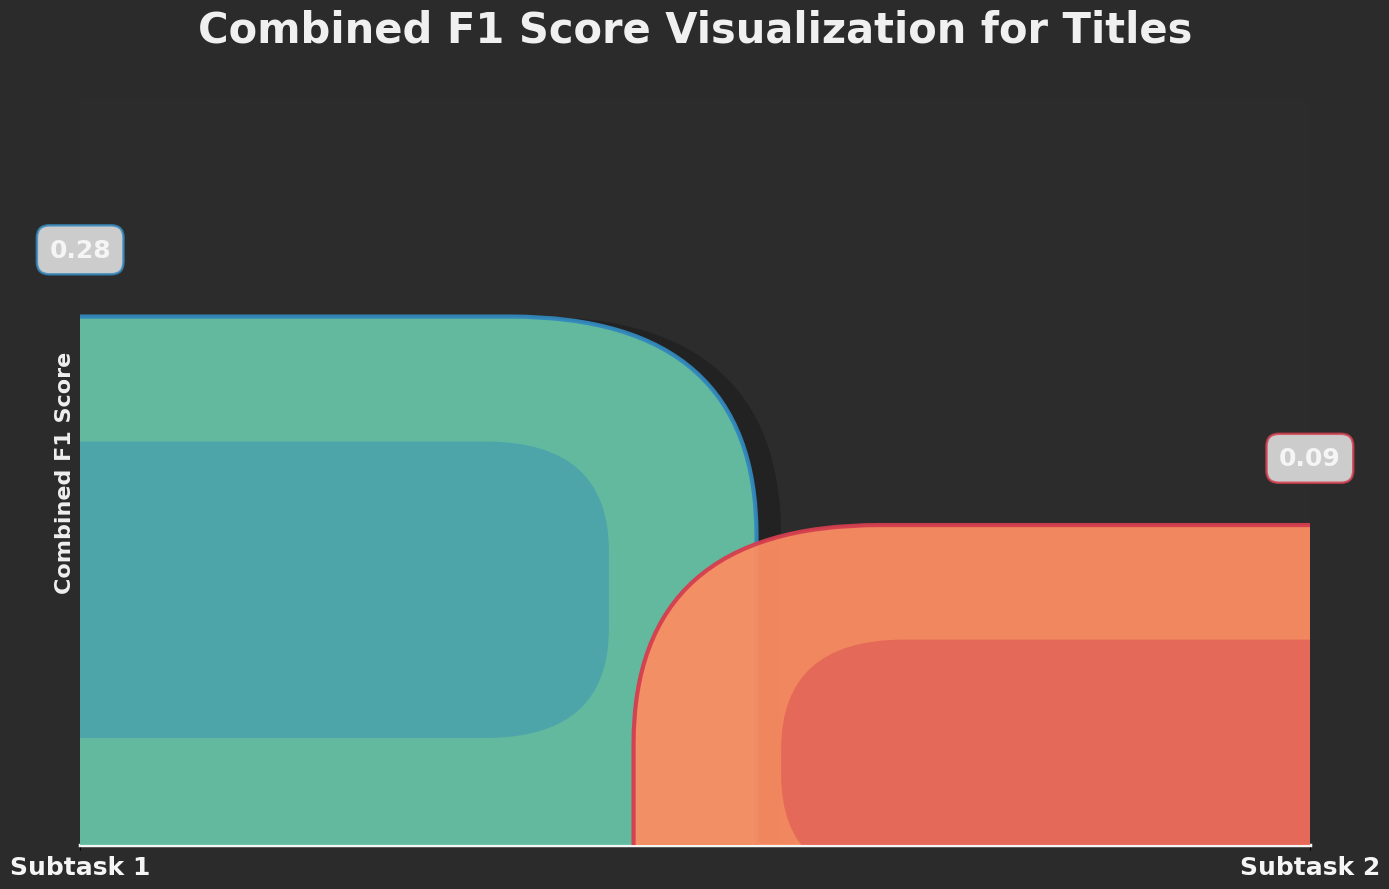

In [212]:
subtask_names = ['Subtask 1', 'Subtask 2']
combined_scores = [combined_score_title_st1, combined_score_title_st2]

# Color palette for a luxurious gradient and artistic effects
gradient_colors = [('#66c2a5', '#3288bd'), ('#fc8d62', '#d53e4f')]
highlight_color = '#f5f5f5'
background_color = '#2b2b2b'
title_color = '#f0f0f0'
shadow_color = '#1a1a1a'

# Plotting configuration
fig, ax = plt.subplots(figsize=(14, 9), facecolor=background_color)
ax.set_facecolor(background_color)

# Add multi-layered glow background to create a sense of depth
circle_1 = plt.Circle((0.5, 0.5), 1.5, color='#333333', alpha=0.1, transform=ax.transAxes, zorder=0)
circle_2 = plt.Circle((0.5, 0.5), 1.2, color='#444444', alpha=0.08, transform=ax.transAxes, zorder=0)
ax.add_patch(circle_1)
ax.add_patch(circle_2)

# Draw gradient bars with artistic design and subtle shadow effects
for idx, (score, colors) in enumerate(zip(combined_scores, gradient_colors)):
    # Use gradients for the bars
    bar = FancyBboxPatch(
        (idx - 0.35, 0),  # Coordinates
        0.7, score,  # Width and height
        boxstyle="round,pad=0.2",  # Rounded corners
        linewidth=3,
        edgecolor=colors[1],  # Outer gradient color
        facecolor=colors[0],  # Primary gradient color
        alpha=0.95,
        zorder=3
    )
    ax.add_patch(bar)

    # Add glow highlight on top of the bar to make it shine
    ax.add_patch(
        FancyBboxPatch(
            (idx - 0.33, score * 0.7),  # Coordinates to make it sit on the bar
            0.66, score * 0.25,  # Width and a fraction of height
            boxstyle="round,pad=0.1",  # Rounded corners
            linewidth=0,
            edgecolor=None,
            facecolor=colors[1],  # Lighter color to simulate glow
            alpha=0.4,
            zorder=4
        )
    )

    # Shadow effect behind bars for depth
    shadow = FancyBboxPatch(
        (idx - 0.35 + 0.02, -0.04),  # Slight offset for shadow
        0.7, score + 0.04,  # Width and height (slightly taller for shadow effect)
        boxstyle="round,pad=0.2",  # Rounded corners
        linewidth=0,
        facecolor=shadow_color,
        alpha=0.5,
        zorder=1  # Draw behind the bar
    )
    ax.add_patch(shadow)

# Add callout annotations above the bars with luxurious formatting
for idx, score in enumerate(combined_scores):
    ax.text(
        idx, score + 0.25,
        f'{score:.2f}',
        ha='center', va='bottom',
        fontsize=18, fontweight='bold',
        color=highlight_color,
        bbox=dict(boxstyle="round,pad=0.5", facecolor=highlight_color, edgecolor=gradient_colors[idx][1], linewidth=1.8, alpha=0.8),
        zorder=5  # Place text on top of everything else
    )

# Customizing the axes, title, and grid for an immersive effect
ax.set_xticks(np.arange(len(subtask_names)))
ax.set_xticklabels(subtask_names, fontsize=18, fontweight='bold', color=highlight_color)
ax.set_ylabel('Combined F1 Score', fontsize=16, fontweight='bold', color=title_color)
ax.set_ylim(0, max(combined_scores) + 0.4)
ax.set_yticks([])  # Hide y-ticks for an elegant look

# Add an enhanced title with rich typography
ax.set_title(
    'Combined F1 Score Visualization for Titles',
    fontsize=30, fontweight='bold', color=title_color, pad=40, loc='center'
)

# Remove unnecessary spines and enhance the bottom spine
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_color(highlight_color)
ax.spines['bottom'].set_linewidth(2.5)

# Adding a soft, artistic dotted grid for readability
ax.yaxis.grid(True, linestyle=':', color='#888888', alpha=0.5)
ax.xaxis.grid(False)

# Adjust layout for balanced spacing and to maintain visual elegance
plt.tight_layout()
plt.show()


#### Predict on validation data title

In [213]:
# Predicting on validation data
val_predictions_hazard_cat_encoded = grid_search_hazard_cat_title.predict(X_val_title)
# Mapping predictions to labels
val_predictions_hazard_cat = np.array([
    class_index_to_label_hazard_cat_title.get(idx, 'unknown') 
    for idx in val_predictions_hazard_cat_encoded
])

# Predict product-category on validation data title
val_predictions_product_cat_encoded = grid_search_product_cat_title.predict(X_val_title)
# Mapping predictions to labels
val_predictions_product_cat = np.array([
    class_index_to_label_product_cat_title.get(idx, 'unknown') 
    for idx in val_predictions_product_cat_encoded
])

# Predict hazard (vector) on validation data title
val_predictions_hazard_encoded = grid_search_hazard_title.predict(X_val_title)
# Mapping predictions to labels
val_predictions_hazard = np.array([
    class_index_to_label_hazard_title.get(idx, 'unknown') 
    for idx in val_predictions_hazard_encoded
])

# Predict product (vector) on validation data title
val_predictions_product_encoded = grid_search_product_title.predict(X_val_title)
# Mapping predictions to labels
val_predictions_product = np.array([
    class_index_to_label_product_title.get(idx, 'unknown') 
    for idx in val_predictions_product_encoded
])




In [214]:
# Save predictions for Subtask 1 title
submission_lr_st1_title = pd.DataFrame({
    'hazard-category': val_predictions_hazard_cat,
    'product-category': val_predictions_product_cat
})

# Save predictions for Subtask 2 title
submission_lr_st2_title = pd.DataFrame({
    'hazard': val_predictions_hazard,
    'product': val_predictions_product
})




In [215]:
# Uncomment to save to CSV
# submission_lr_st1_title.to_csv('path_to_save/submission_lr_st1_title.csv', index=False)
# submission_lr_st2_title.to_csv('path_to_save/submission_lr_st2_title.csv', index=False)


#### **Visualization**

1. **Bar Plots for Combined Scores:**
   - **Gradient Effects:** Horizontal bars with gradient effects highlight performance differences across subtasks.
   - **Color Coding:** 
      - **Teal (Text):** Symbolizes depth and reliability.
      - **Orange (Title):** Reflects focus and clarity.

2. **Glow Effects:**
   - Enhance readability and emphasize critical values.

3. **Annotations:**
   - Numeric values are displayed directly on the bars for clarity.


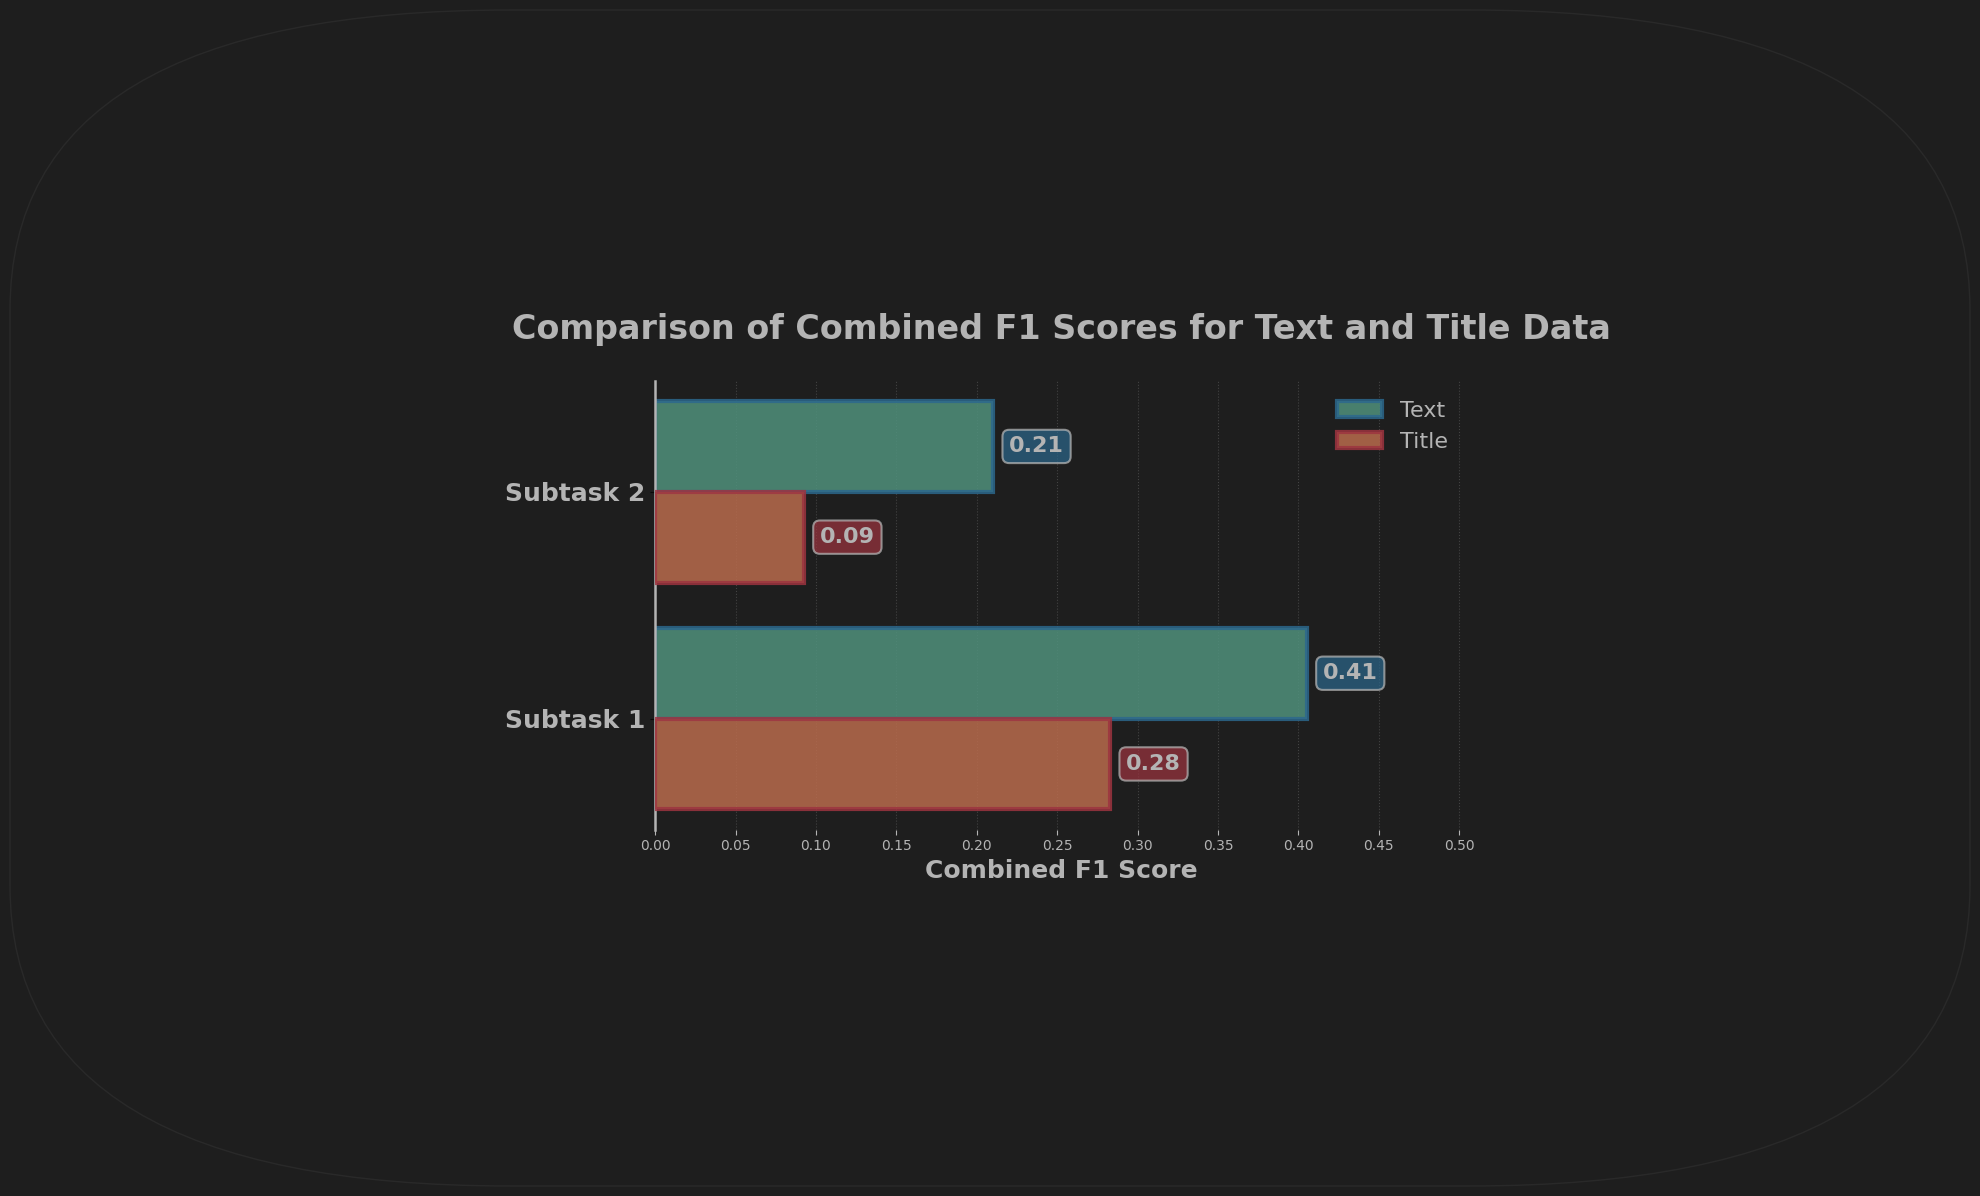

In [216]:
# Data Preparation
subtask_names = ['Subtask 1', 'Subtask 2']
text_scores = [combined_score_text_st1, combined_score_text_st2]
title_scores = [combined_score_title_st1, combined_score_title_st2]

# Styling settings
background_color = '#1e1e1e'
text_color = "#66c2a5"
title_color = "#fc8d62"
highlight_color = "#f5f5f5"

# Plotting the Combined Scores for Text and Titles Side by Side
fig, ax = plt.subplots(figsize=(10, 6), facecolor=background_color)
ax.set_facecolor(background_color)

y = np.arange(len(subtask_names))  # Positions for Subtasks

bar_height = 0.4

# Plotting Horizontal Bars with Gradient and Shadow Effect
for idx, (score_text, score_title) in enumerate(zip(text_scores, title_scores)):
    # Text bar with glow
    ax.barh(y[idx] + bar_height / 2, score_text, height=bar_height, color=text_color, edgecolor='#3288bd', linewidth=3, alpha=0.85, zorder=2)
    ax.barh(y[idx] - bar_height / 2, score_title, height=bar_height, color=title_color, edgecolor='#d53e4f', linewidth=3, alpha=0.85, zorder=3)

    # Add annotations
    ax.text(score_text + 0.01, y[idx] + bar_height / 2,
            f'{score_text:.2f}', ha='left', va='center', fontsize=16, fontweight='bold', color=highlight_color,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='#3288bd', edgecolor='white', linewidth=1.5, alpha=0.7), zorder=4)

    ax.text(score_title + 0.01, y[idx] - bar_height / 2,
            f'{score_title:.2f}', ha='left', va='center', fontsize=16, fontweight='bold', color=highlight_color,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='#d53e4f', edgecolor='white', linewidth=1.5, alpha=0.7), zorder=5)

# Customizing the Axes, Title, and Grid
ax.set_yticks(y)
ax.set_yticklabels(subtask_names, fontsize=18, fontweight='bold', color=highlight_color)
ax.set_xlabel('Combined F1 Score', fontsize=18, fontweight='bold', color=highlight_color)
ax.set_xlim(0, max(max(text_scores), max(title_scores)) + 0.1)
ax.set_xticks(np.arange(0, max(max(text_scores), max(title_scores)) + 0.1, 0.05))
ax.tick_params(axis='x', colors=highlight_color)

# Title and Labels
ax.set_title(
    'Comparison of Combined F1 Scores for Text and Title Data',
    fontsize=24, fontweight='bold', color=highlight_color, pad=30
)

# Add legend to differentiate text and title
ax.legend(['Text', 'Title'], fontsize=16, loc='upper right', frameon=False, facecolor=background_color, labelcolor=highlight_color)

# Adding Grid Lines for Better Readability
ax.xaxis.grid(True, linestyle=':', color='#888888', alpha=0.5)
ax.yaxis.grid(False)

# Remove unnecessary spines for a cleaner look
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color(highlight_color)
ax.spines['left'].set_linewidth(1.8)

# Add subtle shadow effect behind the plot area to make it pop
fig.patch.set_facecolor(background_color)
shadow_box = FancyBboxPatch((0.02, 0.02), 0.96, 0.96, boxstyle="round,pad=0.5", facecolor=background_color, edgecolor='#444444', alpha=0.3, transform=fig.transFigure, zorder=1)
fig.patches.append(shadow_box)

# Adjust layout for better spacing and overall visual appeal
plt.tight_layout()
plt.show() 


## **Conclusions**

### **Key Takeaways**
1. **Text Data:** Consistently outperformed title data.
2. **Macro F1 Scores:** Exposed the challenges of class imbalance, particularly for minority classes.
3. **Logistic Regression:** Provided a robust baseline but struggled with the complexity of Subtask 2.

---

## **Limitations**
1. **Class Imbalance:** Minority class performance was limited due to dataset imbalance.
2. **Model Simplicity:** Logistic Regression's simplicity hindered its ability to capture complex relationships in Subtask 2.

---

## **Future Directions**

### **Handle Class Imbalance**
1. **SMOTE (Synthetic Minority Oversampling Technique):**
   - Generate synthetic samples for underrepresented classes.
   
---
